In [51]:
import pandas as pd
import numpy as np

df = pd.read_csv('played_out.csv', index_col=0)

In [52]:
# Unique users
age_gender = df.groupby(['age', 'gender']).agg({'user':pd.Series.nunique}).reset_index()
age_gender

,age,gender,user
0,20,F,15
1,20,M,14
2,40,F,16
3,40,M,15
4,60,F,15
5,60,M,15


In [53]:
# Songs per user
tracks_per_user = df.groupby(['user']).agg({'track.id':'count'}).reset_index().rename(columns={'track.id':'total_tracks'})
users_per_track_count = tracks_per_user.groupby('total_tracks').agg({'user':'count'}).reset_index().rename(columns={'user':'# of users'})
users_per_track_count

,total_tracks,# of users
0,50,19
1,51,18
2,52,52


In [54]:
# Missing values in dataset

na = df.isna().sum().reset_index().rename(columns={0:'NA', 'index':'Feature'})
na['total'] = 4572
na['% Missing'] = round(100*na['NA']/na['total'], 2)
na = na[na['NA'] > 0]
na

,Feature,NA,total,% Missing
15,accousticness,273,4572,5.97
16,danceability,273,4572,5.97
17,energy,273,4572,5.97
18,instrumentalness,273,4572,5.97
19,key,273,4572,5.97
20,liveness,273,4572,5.97
21,loudness,273,4572,5.97
22,mode,273,4572,5.97
23,speechiness,273,4572,5.97
24,tempo,273,4572,5.97


In [55]:
tracks = df[['track.id', 'accousticness']].drop_duplicates()
tracks['Feature value'] = np.where(tracks['accousticness'].isna(), 'NA', 'OK')
tracks.groupby('Feature value').agg({'track.id':'count'}).reset_index().rename(columns={'track.id':'# of songs'})

,Feature value,# of songs
0,NA,49
1,OK,633


In [56]:
genre_df = df[['user', 'first_genre', 'position', 'track.id', 'accousticness']].drop_duplicates()
genre_df = genre_df.sort_values(['user', 'position']).reset_index(drop=True)

genre_na = genre_df[genre_df['accousticness'].isna()]
genre_na_summary = genre_na.groupby('first_genre').agg({'track.id': 'nunique'}).reset_index()
genre_na_summary = genre_na_summary.rename(columns={'track.id': 'Songs with missing audio features'})

pos_0_na = genre_df[(genre_df['accousticness'].isna()) & (genre_df['position'] == 0)]
pos_0_summary = pos_0_na.groupby('first_genre').agg({'track.id': 'nunique'}).reset_index()
pos_0_summary = pos_0_summary.rename(columns={'track.id': 'Missing features at position 0'})

genre_na = genre_na_summary.merge(pos_0_summary, on='first_genre', how='left')

genre_na['Missing features at position 0'] = genre_na['Missing features at position 0'].fillna(0).astype(int)

genre_na

,first_genre,Songs with missing audio features,Missing features at position 0
0,1,11,0
1,2,15,1
2,3,18,0
3,4,5,0
4,5,10,1


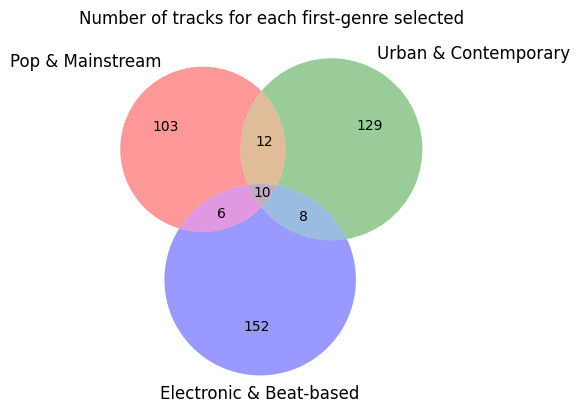

In [57]:
# Song overlap between genres

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

genre_1 = set(df[df['first_genre'] == 1]['track.id'].unique())
genre_2 = set(df[df['first_genre'] == 2]['track.id'].unique())
genre_3 = set(df[df['first_genre'] == 3]['track.id'].unique())

venn3([genre_1, genre_2, genre_3], ('Pop & Mainstream', 'Urban & Contemporary', 'Electronic & Beat-based'))

plt.title("Number of tracks for each first-genre selected")
plt.show()

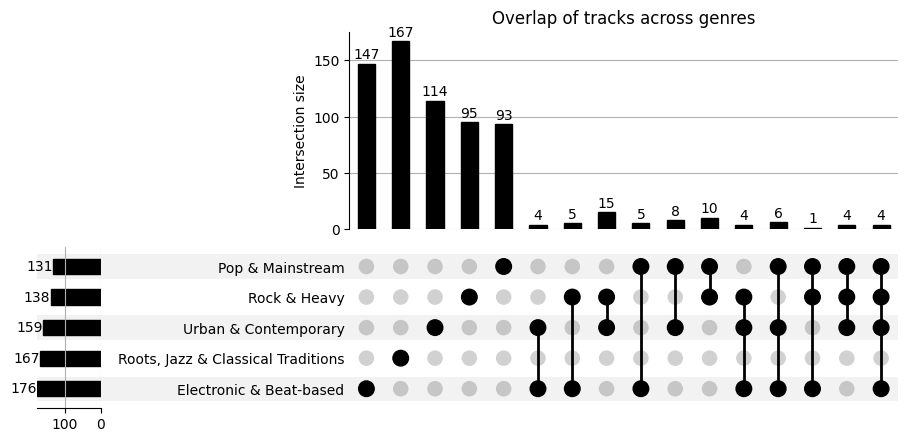

In [58]:
from upsetplot import from_contents, plot
import matplotlib.pyplot as plt
# Source - https://stackoverflow.com/a
# Posted by astrofrog, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-28, License - CC BY-SA 4.0

import warnings
warnings.filterwarnings('ignore')

genre_data = {
    'Pop & Mainstream': df[df['first_genre'] == 1]['track.id'].unique(),
    'Urban & Contemporary': df[df['first_genre'] == 2]['track.id'].unique(),
    'Electronic & Beat-based': df[df['first_genre'] == 3]['track.id'].unique(),
    'Rock & Heavy': df[df['first_genre'] == 4]['track.id'].unique(),
    'Roots, Jazz & Classical Traditions': df[df['first_genre'] == 5]['track.id'].unique()
}

upset_data = from_contents(genre_data)

plot(upset_data, subset_size='count', show_counts=True)
plt.title("Overlap of tracks across genres")
plt.show()

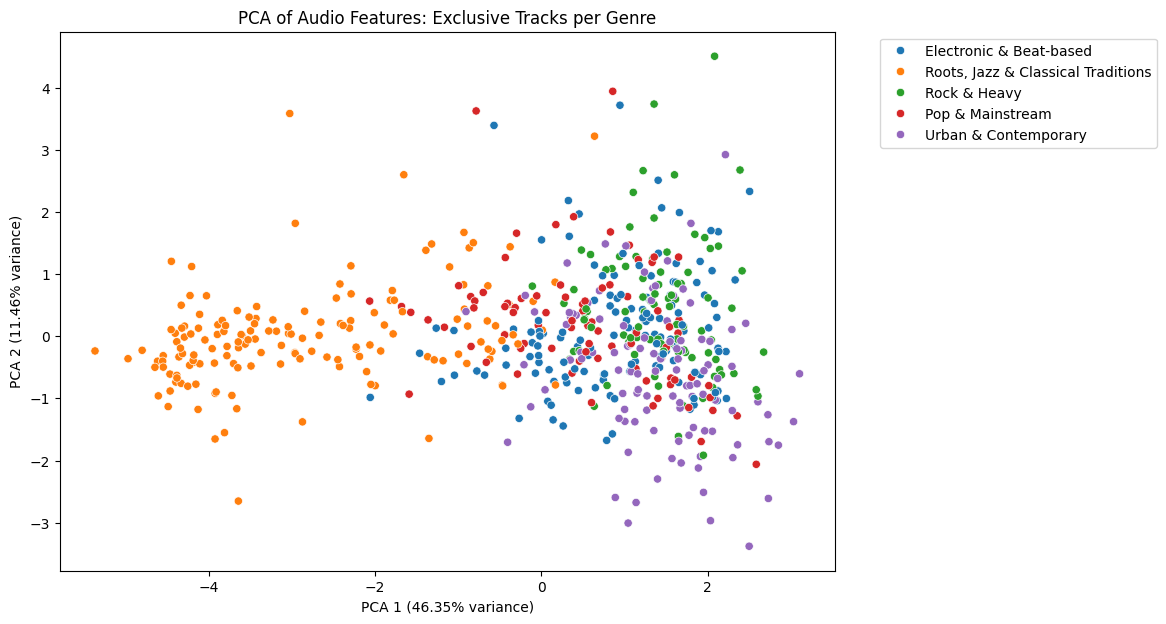

In [ ]:
# audio_features = [
#     'accousticness', 'danceability', 'energy', 'instrumentalness', 
#     'key', 'liveness', 'loudness', 'mode', 
#     'speechiness', 'tempo', 'valence'
# ]

# tracks = df[['track.id']+ audio_features + ['first_genre']].drop_duplicates()
# tracks.head()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Identify "Exclusive" tracks (those that belong to only one genre)
# We count how many unique genres each track ID is associated with
track_counts = df.groupby('track.id')['first_genre'].nunique()
exclusive_ids = track_counts[track_counts == 1].index

# Filter the original tracks dataframe to keep only exclusive tracks
exclusive_df = tracks[tracks['track.id'].isin(exclusive_ids)].copy()

# 2. Define features for PCA
audio_features = [
    'accousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Drop rows with missing values in these features
exclusive_df = exclusive_df.dropna(subset=audio_features)

# 3. Normalize the data
# Since features like 'tempo' (0-250) and 'loudness' (-60 to 0) are on different scales, 
# normalization is required for PCA to work correctly.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(exclusive_df[audio_features])

# 4. Perform PCA (Reduce to 2 components for 2D visualization)
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_features)

exclusive_df['PCA1'] = pca_results[:, 0]
exclusive_df['PCA2'] = pca_results[:, 1]
exclusive_df['PCA3'] = pca_results[:, 2]

# 5. Mapping genre IDs to names for the legend
# Adjust the mapping based on your data structure
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}
exclusive_df['Genre Name'] = exclusive_df['first_genre'].map(genre_mapping)

# 6. Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=exclusive_df, 
    x='PCA1', y='PCA2', 
    hue='Genre Name', 
    palette='tab10'
)

plt.title("PCA of Audio Features: Exclusive Tracks per Genre")
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

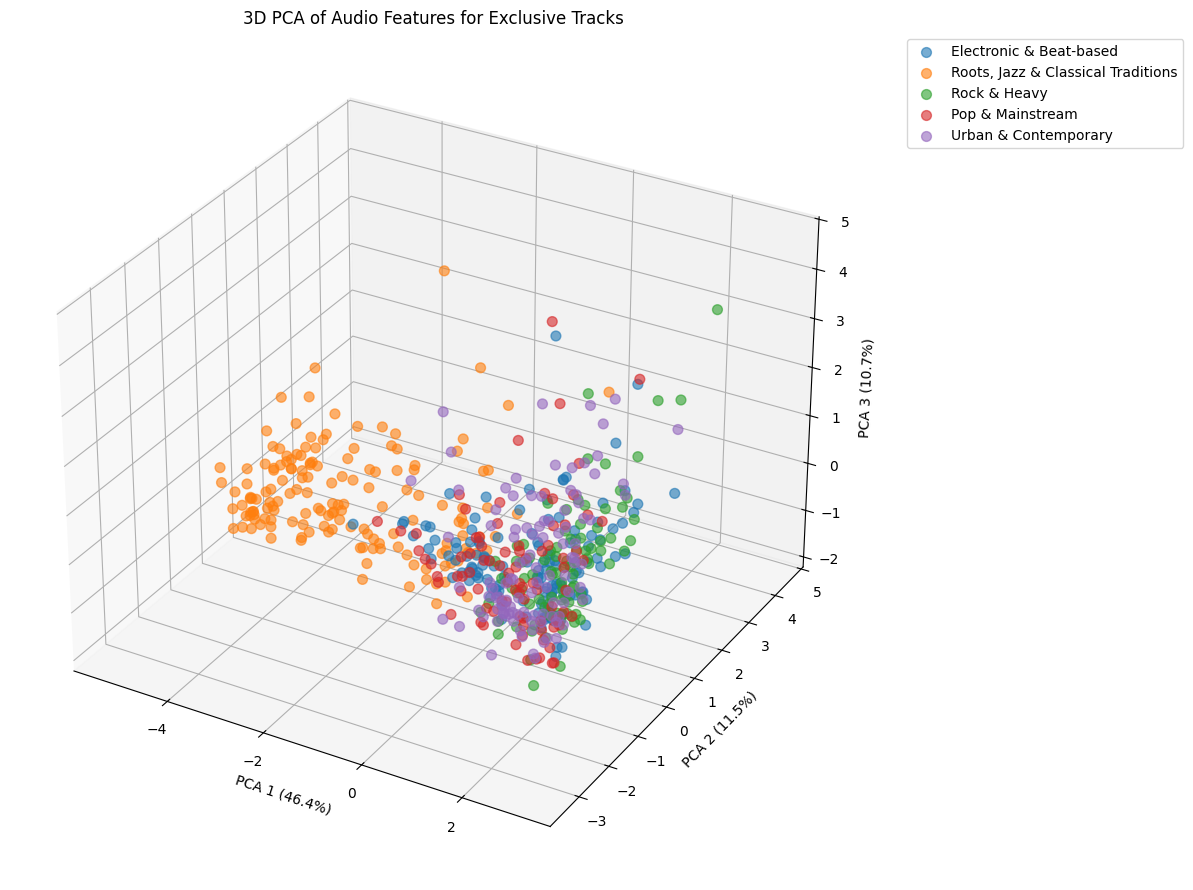

Total variance explained by 3 components: 68.51%


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Identify "Exclusive" tracks (those belonging to only one genre)
track_counts = df.groupby('track.id')['first_genre'].nunique()
exclusive_ids = track_counts[track_counts == 1].index
exclusive_df = tracks[tracks['track.id'].isin(exclusive_ids)].copy().dropna(subset=audio_features)

# 2. Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(exclusive_df[audio_features])

# 3. Perform PCA with 3 components
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_features)

exclusive_df['PCA1'] = pca_results[:, 0]
exclusive_df['PCA2'] = pca_results[:, 1]
exclusive_df['PCA3'] = pca_results[:, 2]

# 4. Define Genre Mapping (ensure these match your actual data)
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}
exclusive_df['Genre Name'] = exclusive_df['first_genre'].map(genre_mapping)

# 5. Build the 3D Scatter Plot (Corrected Version)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') # Simple and direct

# Iterate through genres to plot each with a unique color
for genre in exclusive_df['Genre Name'].unique():
    subset = exclusive_df[exclusive_df['Genre Name'] == genre]
    ax.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], 
               label=genre, alpha=0.6, s=50)

# Labeling axes with the variance explained
var_exp = pca.explained_variance_ratio_
ax.set_xlabel(f'PCA 1 ({var_exp[0]:.1%})')
ax.set_ylabel(f'PCA 2 ({var_exp[1]:.1%})')
ax.set_zlabel(f'PCA 3 ({var_exp[2]:.1%})')

plt.title("3D PCA of Audio Features for Exclusive Tracks")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print total variance for your analysis
print(f"Total variance explained by 3 components: {sum(var_exp):.2%}")